In [1]:

import json, nltk, re, os, codecs

import pandas as pd
from pandas.io.json import json_normalize
#import pandas_profiling
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
#alt.renderers.enable("notebook")

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn import feature_extraction

from pymongo import MongoClient
from nltk.tokenize import word_tokenize

In [2]:
import pandas as pd
import numpy as np
import re
import pickle
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
import warnings

warnings.simplefilter('ignore')

import pickle
from sklearn.externals import joblib

[nltk_data] Downloading package punkt to /home/kells/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kells/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def connect():
    connection = MongoClient('10.10.250.0', 27017)
    handle = connection["projectfinder"]
    return handle
db = connect()


In [4]:
db_loc = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'db' : 'projectfinder',
    'coll' : 'itproject_clean'
}

In [5]:
db_data = {
    'ip' :'10.10.250.0',
    'port' : 27017,
    'db' : 'projectfinder',
    'coll' : 'mldata1'
}

In [6]:
def load_data_from_momgodb(db_obj):
    dbname = db_obj['db']
    ip = db_obj['ip']
    port = db_obj['port']
    coll = db_obj['coll']
    connection = MongoClient(ip,port)
    db = connection[dbname]
    exclude_data = {'_id': False}
    raw_data = list(db[coll].find({}, projection=exclude_data))
    dataset = pd.DataFrame(raw_data)
    print(f'Data loaded from mongodb {coll} collection succesfully')
    return dataset

In [7]:
def save_to_momgodb(df,db_):
    data = df.to_dict(orient='records')
    dbname = db_['db']
    ip = db_['ip']
    port = db_['port']
    coll = db_['coll']
    connection = MongoClient(ip,port)
    db = connection[dbname]
    col = db[coll].insert_many(data)
    print(f'data saved as {coll}')

In [8]:
def load_data_from_json(data):
    with open(data) as f:
            d = json.load(f)
        #normalize json
    dataset= json_normalize(d)
    return dataset

In [9]:
def clean_dataset(data):
    #select colunms
    df = data[['description', 'bereich']]
    df = df[df['description'] != '']
    df['project'] = df['description']
    df['label'] = df['bereich']
    df.drop(['description', 'bereich'], axis=1, inplace=True)
    df = df[df['label'] != 'IT/Bauingenieur']
    df = df.drop_duplicates()
    return df

In [37]:
data = load_data_from_momgodb(db_loc)

Data loaded from mongodb itproject_clean collection succesfully


In [38]:
df = clean_dataset(data)
df.head()


,project,label
0,Für einen unserer Kunden aus dem Finanzdienstl...,Infr-Admin-Microsoft
1,Kann Profil leider nicht löschen.,IT/Consulting
2,Business Intelligence Analyst (m/w) - Tableau ...,Data-Sci-BI
3,"Konzeption, Customizing sowie Softwareanpassun...",Infr-Admin-Linux
4,Es sollen mehrere Automatisierungen mit ubot S...,IT/IT


In [34]:
df.shape

(12168, 2)

In [333]:
# df['label'].replace(['IT/Admin-Oracle', IT-Technical-Dev], 'INF-Admin-Database', inplace=True)
df['label'].replace(['IT-HW-Technisches', 'IT-Technical-Dev'], 'IT-Tech', inplace=True)
df['label'].replace(['DS-ML','DS-BI', 'IT/Business Int'], 'Data-DS-Analysis', inplace=True)
df['label'].replace(['IT-Admin-Linux'], 'INF-Admin-Linux', inplace=True)
df['label'].replace(['IT/Management (','IT/Projektleitu','IT/Fertigungste', 'IT/Consulting', 'IT/Project Mgmt'], 'INF-Consulting-PM', inplace=True)
df['label'].replace(['SW/Tester','IT/Softwareentw','IT/Qualitätsman','IT/Weitere IT-Q'], 'Dev-Web-Fullstack', inplace=True)
df['label'].replace(['IT/Automatisier','IT/Software Arc'], 'SW-Dev-Devops', inplace=True)
df['label'].replace(['IT/Admin-CITRIX','IT/Admin-ITIL', 'IT/Admin-Netwerk-Cisco'], 'INF-Admin-Others', inplace=True)
df['label'].replace(['IT/Maschinen- /','IT/Konstruktion', 'IT/Mess- / Rege', 'IT/Fahrzeugbau', 'IT/Hardware-Ent', 'IT/Engineering', 'IT/Elektrotechn', 'IT/Technisches '], 'IT-HW-Technisches', inplace=True)

In [336]:
df = df.apply(lambda x: x.mask(x.map(x.value_counts())<100, 'other') if x.name!='project' else x)

In [39]:
df['label'].replace(['IT-Admin-Net'], 'Infr-Admin-Net', inplace=True)
#df['label'].replace(['Data-Sci-ML'], 'Data-Sci-BI ', inplace=True)

In [30]:
df.head(10)

,project,label
0,Für einen unserer Kunden aus dem Finanzdienstl...,Infr-Admin-Microsoft
1,Kann Profil leider nicht löschen.,IT/Consulting
2,Business Intelligence Analyst (m/w) - Tableau ...,Data-Sci-BI
3,"Konzeption, Customizing sowie Softwareanpassun...",Infr-Admin-Linux
4,Es sollen mehrere Automatisierungen mit ubot S...,IT/IT
5,Unser Projekt beinhaltet Spieleentwicklung für...,IT/IT
6,Future Consulting GmbH \r\nentscheiden Sie sic...,IT-Mgmt-Consulting
7,"Als Mitglied eines kleinen, dynamischen Teams ...",Infr-Admin-Microsoft
8,Über unseren Kunden: \n \n Unser Kunde ist e...,Infr-Admin-Microsoft
9,Über unseren Kunden: \n \n Unser Kunde ist e...,Dev-Web-Backend


In [15]:
df = df[df['label'] != 'other']
df.shape

(12168, 2)

In [16]:
df.dropna()
df.shape

(12168, 2)

In [15]:
categories = df.label.str.split(pat='-',expand=True)
categories.head()

,0,1,2
0,Infr,Admin,Microsoft
2,Data,Sci,BI
3,Dev,Web,Backend
6,IT,Mgmt,Consulting
7,Infr,Admin,Microsoft


In [335]:
sap = df.index[df['label'] == 'ERP-SAP']
len(sap)

963

In [336]:
df.drop(sap[:int(len(sap) * 0.3)], inplace=True)   #to create a new DataFrame, if you want to modify the original one, put inplace=True

In [337]:
back = df.index[df['label'] == 'Dev-Web-Backend']
len(back)

910

In [338]:
df.drop(back[:int(len(back) * 0.3)], inplace=True)   #to create a new DataFrame, if you want to modify the original one, put inplace=True

In [340]:
full = df.index[df['label'] == 'Dev-Web-Fullstack']
len(full)

939

In [341]:
mic = df.index[df['label'] == 'Infr-Admin-Microsoft']
len(mic)

849

In [342]:
other = df.index[df['label'] == 'SW-Dev-Others']
len(other)

814

In [343]:
con = df.index[df['label'] == 'IT-Mgmt-Consulting']
len(con)

812

In [344]:
proj = df.index[df['label'] == 'IT-Mgmt-Projectleiter']
len(proj)

723

In [349]:
df.drop(proj[:int(len(proj) * 0.3)], inplace=True)   #to create a new DataFrame, if you want to modify the original one, put inplace=True

In [41]:
df['label'].value_counts()

ERP-SAP                  1710
Dev-Web-Backend          1439
IT-Mgmt-Projectleiter     980
Dev-Web-Fullstack         881
Infr-Admin-Microsoft      767
SW-Dev-Others             697
IT-Mgmt-Consulting        628
Dev-Web-Frontend          597
Data-Engr-Big Data        572
Data-Sci-BI               532
Infr-Database-Admin       478
SW-Dev-Mobile             320
Infr-Admin-Linux          283
Infr-Admin-Database       272
IT-Security               248
Infr-Admin-Net            231
IT-Technical-Dev          201
Dev-Devops                165
IT-Admin-Others           160
IT/Elektrotechn           113
IT/Automatisier            96
IT/Installation            44
IT/Weitere IT-Q            41
IT/Fahrzeugbau             39
IT/Mess- / Rege            37
IT/Konstruktion            34
IT/Plattformen             32
IT/Rechnungswes            31
IT/Softwareentw            28
IT/Fertigungste            26
                         ... 
IT/Front-end, O             1
IT/Einkauf Proj             1
IT/Applika

In [341]:
df.shape

(11255, 2)

In [352]:
sap = df.index[df['label'] == 'ERP-SAP']
backend = df.index[df['label'] == 'Dev-Web-Backend ']
fullstack = df.index[df['label'] == 'Dev-Web-Fullstack']
ms = df.index[df['label'] == 'Infr-Admin-Microsoft']
sw_others = df.index[df['label'] == 'SW-Dev-Others']
consulting = df.index[df['label'] == 'IT-Mgmt-Consulting']
projectleiter = df.index[df['label'] == 'IT-Mgmt-Projectleiter']
database = df.index[df['label'] == 'Infr-Admin-Database']
dataengr = df.index[df['label'] == 'Data-Engr-Big Data']
frontend = df.index[df['label'] == 'Dev-Web-Frontend']
tech = df.index[df['label'] == 'IT-Tech']
bi = df.index[df['label'] == 'Data-Sci-BI']
adminnet = df.index[df['label'] == 'Infr-Admin-Net']
admothers = df.index[df['label'] == 'IT-Admin-Others']
mobile = df.index[df['label'] == 'SW-Dev-Mobile']
linux = df.index[df['label'] == 'Infr-Admin-Linux']
devops = df.index[df['label'] == 'Dev-Devops']

In [353]:
len(sap)

1925

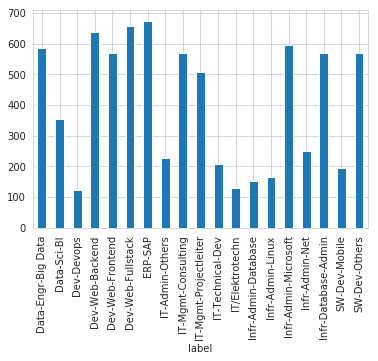

In [353]:
df.groupby('label').size().plot(kind='bar')

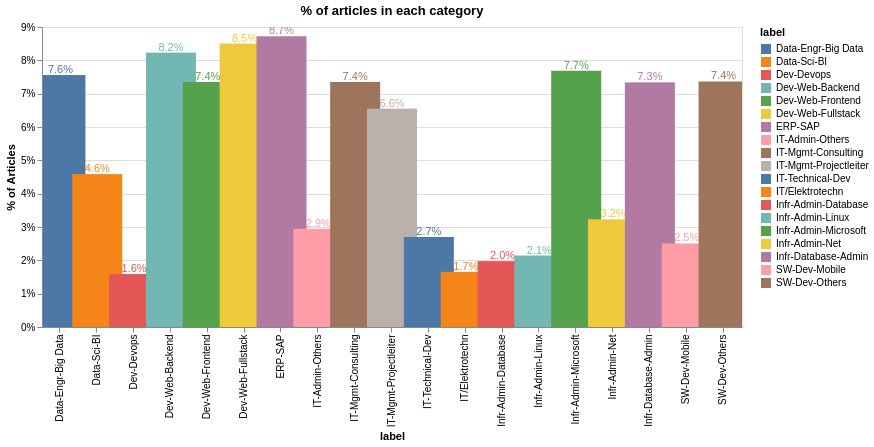

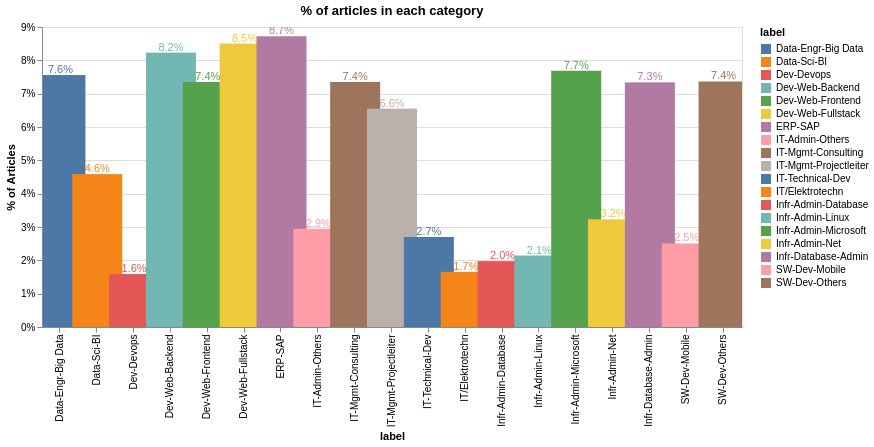

In [354]:
df['id'] = 1
df2 = pd.DataFrame(df.groupby('label').count()['id']).reset_index()
alt.data_transformers.disable_max_rows()
bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('label'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Articles')),
    color='label'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each category",
)

In [356]:
categories = pd.get_dummies(df['label'])
df_new = pd.concat([df, categories], axis=1)
df_new.head()


,project,label,id,Data-Engr-Big Data,Data-Sci-BI,Dev-Devops,Dev-Web-Backend,Dev-Web-Frontend,Dev-Web-Fullstack,ERP-SAP,...,IT-Mgmt-Projectleiter,IT-Technical-Dev,IT/Elektrotechn,Infr-Admin-Database,Infr-Admin-Linux,Infr-Admin-Microsoft,Infr-Admin-Net,Infr-Database-Admin,SW-Dev-Mobile,SW-Dev-Others
2,Business Intelligence Analyst (m/w) - Tableau ...,Data-Sci-BI,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Über unseren Kunden: \n \n Unser Kunde ist T...,Dev-Web-Frontend,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14,suche für Gestaltung von Produkten und Webseit...,Dev-Web-Frontend,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15,Über unseren Kunden: \n \n Unser Kunde ist e...,Dev-Web-Frontend,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17,Ihre Aufgaben: \n \n Mitarbeit in einem IT...,Infr-Admin-Linux,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [360]:
# drop the original categories column from `df`
df_new = df_new.drop([ 'id'],axis=1)
df_new.head()

,project,Data-Engr-Big Data,Data-Sci-BI,Dev-Devops,Dev-Web-Backend,Dev-Web-Frontend,Dev-Web-Fullstack,ERP-SAP,IT-Admin-Others,IT-Mgmt-Consulting,IT-Mgmt-Projectleiter,IT-Technical-Dev,IT/Elektrotechn,Infr-Admin-Database,Infr-Admin-Linux,Infr-Admin-Microsoft,Infr-Admin-Net,Infr-Database-Admin,SW-Dev-Mobile,SW-Dev-Others
2,Business Intelligence Analyst (m/w) - Tableau ...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,Über unseren Kunden: \n \n Unser Kunde ist T...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,suche für Gestaltung von Produkten und Webseit...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,Über unseren Kunden: \n \n Unser Kunde ist e...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,Ihre Aufgaben: \n \n Mitarbeit in einem IT...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [27]:
df_new.to_csv('pf_ready.csv', index=False)

In [28]:
data = pd.read_csv('pf_ready.csv')
data.head()
data.shape

(11106, 20)

In [29]:
save_to_momgodb(data, db_data)

data saved as mldata1


In [31]:
ready_data = load_data_from_momgodb(db_data)
ready_data.head()

Data loaded from mongodb mldata1 collection succesfully


,Data-Engr-Big Data,Data-Sci-BI,Dev-Devops,Dev-Web-Backend,Dev-Web-Frontend,Dev-Web-Fullstack,ERP-SAP,IT-Admin-Others,IT-Mgmt-Consulting,IT-Mgmt-Projectleiter,IT-Technical-Dev,IT/Elektrotechn,Infr-Admin-Database,Infr-Admin-Linux,Infr-Admin-Microsoft,Infr-Admin-Net,Infr-Database-Admin,SW-Dev-Mobile,SW-Dev-Others,project
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,Für einen unserer Kunden aus dem Finanzdienstl...
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Business Intelligence Analyst (m/w) - Tableau ...
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Konzeption, Customizing sowie Softwareanpassun..."
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Future Consulting GmbH \r\nentscheiden Sie sic...
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"Als Mitglied eines kleinen, dynamischen Teams ..."


In [312]:
feature = ready_data['project']
target = ready_data.drop('project', axis=1)
target_name = list(target.columns.values)

In [33]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

In [34]:
print("rocks :", lemmatizer.lemmatize("running")) 
print("corpora :", lemmatizer.lemmatize("corpora"))
print("better :", lemmatizer.lemmatize("running", pos ="v"))

rocks : running
corpora : corpus
better : run


In [35]:
#german cities
from bundeslander import Baden_Württemberg, Bayern, Berlin, Brandenburg, Bremen, Hamburg, Hessen, Mecklenburg_Vorpommern, Niedersachsen, Nordrhein_Westfalen, Rheinland_Pfalz, Saarland, Sachsen, Sachsen_Anhalt, Schleswig_Holstein, Thüringen, Ausland
All = Baden_Württemberg + Bayern + Berlin + Brandenburg + Bremen +Hamburg + Hessen + Mecklenburg_Vorpommern + Niedersachsen + Nordrhein_Westfalen + Rheinland_Pfalz + Saarland + Sachsen + Sachsen_Anhalt + Schleswig_Holstein + Thüringen + Ausland
cities = list(set([city.lower() for city in All]))

In [36]:
#load saved model
import pickle
from sklearn.externals import joblib
#filename = '../stopwords.sav'
#stopwords = joblib.load(filename)

In [37]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [46]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

lemmatize_sent('He is walking to school')

['he', 'be', 'walk', 'to', 'school']

In [39]:
import enchant
d = enchant.Dict("en_US")
d.check('hello')

In [320]:
new_stop = ['know','com','schnittstellen', 'lösungen','solutions', 'user','position','bestehenden']
new_stop1 = ['rückmeldung', 'contractor', 'berufserfahrung', 'dienstleister',  'absprache', 'umfangreiche']
new_stop2 = ['tag', 'kollegen', 'fachliche', 'verständnis', 'hr', 'tätigkeiten', 'gl', 'umgebung', '§§', 'gr']
new_stop3 = ['hands', 'aufgabenbeschreibung', 'anpassung', 'gemäß', 'durchführen','hören', 'ausgeprägte']
new_stop4 = ['interessant', 'kontaktaufnahme', 'deutschland', 'via', 'sprachen', 'mitbringen', 'lebenslauf']
new_stop5 = ['st', 'bewertung', 'langjährige', 'grundkenntnisse', 'erforderlich', 'abgeschlossenes', 'externe']
new_stop6 = ['bereitstellung', 'festanstellung', 'reviews', 'projektsprache', 'fähigkeit', 'beschreibung']

In [321]:
import nltk
with open('german_stopwords_full.txt', 'r') as f:
    stopwords_germ = f.read().splitlines()

stopwords_eng = nltk.corpus.stopwords.words('english')
stopwords = stopwords_eng + stopwords_germ + cities + new_stop + new_stop1 + new_stop2 + new_stop3 + new_stop4 + new_stop5 + new_stop6

In [283]:
pickle.dump(stopwords, open('stopwords_sl', 'wb'))

In [324]:
av = {
    'entwick': 'entwicklung',
    'automat': 'automate',
    'scrum': 'scrum',
    'container': 'containerization',
    'admin': 'administration',
    'analys': 'analyst',
    'app': 'application',
    'developer': 'entwicklung',
    'programming': 'entwicklung',
    'mobil': 'mobil',
    'berater': 'run'
}

In [325]:
import string
from string import punctuation

In [326]:
def tokenize(text):
    """Normalize, tokenize and stem text string
    
    Args:
    text: string. String containing message for processing
       
    Returns:
    stemmed: list of strings. List containing normalized and stemmed word tokens
    """
    # Stem word tokens and remove stop words
    #stemmer_eng = SnowballStemmer("english", ignore_stopwords=True)
    #stemmer_germ = SnowballStemmer("german", ignore_stopwords=True) 
    try:
        # Convert text to lowercase and remove punctuation
        text = re.sub(r'(\d)',' ',text.lower())
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #remove non alphbetic text

        # Tokenize words
        #tokens = word_tokenize(text)
        #print(tokens)
        
        tokens = word_tokenize(text)
        stemmed = [word for word in tokens if word not in stopwords and len(word) > 1]
        #stemmed = [stemmer_eng.stem(word) for word in stemmed if len(word) > 1]
        #stemmed = [word for word in tokens if word not in stopwords and len(word) > 1]
        for index, word in enumerate(stemmed):
            for key, value in av.items():
                if key in word:
                    stemmed[index] = value
        
        #stemmed = [word for word in stemmed if word not in stopwords and len(word) > 2]
    except IndexError:
        pass

    return stemmed

In [327]:
tokenize(' beschreibung  entwicklung bin ich i love running  i am a jumped runner entwickler softwareentwickler')

['entwicklung',
 'love',
 'running',
 'jumped',
 'runner',
 'entwicklung',
 'entwicklung']

In [ ]:
feature_train = fea

In [284]:
text_new = """
Sie suchen ein neues Projekt?
Für ein Kundenprojekt sucht Experis Sie als SAP Basis Administrator (m/w/d) am Standort Hannover.


Aufgaben:
Durchführen von Transitions- und/oder Migrationsprojekte bei Neu- und Bestandskunden mit diversen Plattformen (häufig Einbindung von Fremdlandschaften in IT-Systemlandschaft)


Sprachkenntnisse: Deutsch

Einsatzort: Hannover

Laufzeit: 

Skills:
Project Execution & Control
System Administration
Project Management Experience - Transition Projects
SAP Basis
SAP Migration
SAP Transport Management System (STMS)
Das richtige Projekt?
Bei Interesse senden Sie uns bitte Ihr Profil unter Angabe des Projektnamens sowie des jeweiligen Ansprechpartners. Über eine Info zu Ihrer Verfügbarkeit (räumlich und zeitlich) sowie der Angabe Ihres Stundensatzes sind wir dankbar.

Wir leben Vielfalt und Chancengleichheit und freuen uns deshalb natürlich über Bewerbungen von Menschen mit Behinderung. Alle personenbezogenen Formulierungen in dieser Stellenanzeige sind geschlechtsneutral zu betrachten.
"""

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter('ignore')

In [126]:
np.random.seed(17)
X_train, X_test, Y_train, Y_test = train_test_split(feature, target, random_state = 42)

In [ ]:
{'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 25,
 'tfidf__use_idf': False,
 'vect__min_df': 1}

In [131]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer = tokenize, min_df = 1, ngram_range=(1,2))),
        ('tfidf', TfidfTransformer(use_idf = False)),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators = 25,
                                                             min_samples_split = 2)))
    ])

In [132]:
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

In [282]:
pickle.dump(pipeline, open('models/new_model', 'wb'))

In [139]:
new_pred_test = pipeline.predict(X_test)

In [140]:
eval_metrics = get_eval_metrics(np.array(Y_test), new_pred_test, col_names)

print(eval_metrics)

                       Accuracy  Precision    Recall        F1
Data-Engr-Big Data     0.988835   0.977064  0.788889  0.872951
Data-Sci-BI            0.993517   0.985507  0.800000  0.883117
Dev-Devops             0.998379   1.000000  0.847458  0.917431
Dev-Web-Backend        0.971727   0.953560  0.829071  0.886969
Dev-Web-Frontend       0.984693   0.944186  0.735507  0.826884
Dev-Web-Fullstack      0.975509   0.927649  0.768737  0.840749
ERP-SAP                0.988475   0.977505  0.957916  0.967611
IT-Admin-Others        0.994598   0.960396  0.788618  0.866071
IT-Mgmt-Consulting     0.983252   0.970930  0.800959  0.877792
IT-Mgmt-Projectleiter  0.981632   0.979310  0.747368  0.847761
IT-Technical-Dev       0.993877   0.946667  0.702970  0.806818
IT/Elektrotechn        0.997119   0.950000  0.730769  0.826087
Infr-Admin-Database    0.995318   0.968750  0.720930  0.826667
Infr-Admin-Linux       0.997659   1.000000  0.831169  0.907801
Infr-Admin-Microsoft   0.983612   0.972452  0.813364  0

In [228]:
feature[1]

'Business Intelligence Analyst (m/w) - Tableau Desktop \r\n \r\n \r\nFür ein Kundenprojekt suchen wir Sie als \r\n \r\n Business Intelligence Analyst (m/w) - Tableau Desktop. \r\n \r\nDer Kunde hat ein sehr hohes, kontinui ...'

In [237]:
col_names

['Data-Engr-Big Data',
 'Data-Sci-BI',
 'Dev-Devops',
 'Dev-Web-Backend',
 'Dev-Web-Frontend',
 'Dev-Web-Fullstack',
 'ERP-SAP',
 'IT-Admin-Others',
 'IT-Mgmt-Consulting',
 'IT-Mgmt-Projectleiter',
 'IT-Technical-Dev',
 'IT/Elektrotechn',
 'Infr-Admin-Database',
 'Infr-Admin-Linux',
 'Infr-Admin-Microsoft',
 'Infr-Admin-Net',
 'Infr-Database-Admin',
 'SW-Dev-Mobile',
 'SW-Dev-Others']

In [175]:
test_data = []
for data in X_test:
    test_data.append(data)

In [177]:
test_data[11]

'Für unseren langjährigen Kunden suchen wir ab Januar 2019 einen SAP CS Berater. \r\nIhre Hauptaufgabe besteht in der Sicherstellung des laufenden Systemsbetriebs und der Unterstützung bei den Serviceaufträgen.  \r\n \r\nAufgaben: \r\n• SAP CS Support \r\n• Support bei dem Tagesgeschäft \r\n• Debuggen und Durchführung kleinerer Bugfixes \r\n \r\n \r\nBenötigte Erfahrung: \r\n• Gute Kenntnisse im SAP CS \r\n• Kenntnisse im Bereich Serviceaufträge \r\n• ABAP Kenntnisse (Lesen und Debugging) \r\n \r\n \r\nProjektdetails: \r\n• Start: Januar 2019 \r\n• Laufzeit: 6 Monate (+ Verlängerungsoption) \r\n• Auslastung: 2-3 Tage/Woche \r\n• Ort: 100% Remote \r\n• Sprachen: Deutsch \r\n \r\nTelefonische Interviews mit unserem Kunden können kurzfristig vereinbart werden, mit schneller Entscheidung im Anschluss. \r\nBei Interesse an diesem Projekt, oder wenn Sie hierfür jemanden empfehlen können, kommen Sie gerne auf mich zu.'

In [280]:
get_category_prob(text_new, pipeline, col_names)

('SW-Dev-Mobile', 0.4)

In [261]:
def get_category_prob(text, model, labels):
    predicted_prob_distr = model.predict_proba([text])
    results = [val[0][1] for val in predicted_prob_distr]
    predicted_index = np.argmax(results)
    prediction_percentage = max(results)
    return labels[predicted_index], prediction_percentage
    

In [243]:
def get_category(text, model, labels):
    class_labels = model.predict([text])
    prob = model.predict_proba
    #classification_results = dict(zip(labels.columns, class_labels))
    return class_labels
    

In [133]:
# Define performance metric for use in grid search scoring object
def performance_metric(y_true, y_pred):
    """Calculate median F1 score for all of the output classifiers
        Args:
        y_true: array. Array containing actual labels.
        y_pred: array. Array containing predicted labels.
        Returns:
        score: float. Median F1 score for all of the output classifiers
        """
    f1_list = []
    for i in range(np.shape(y_pred)[1]):
        f1 = f1_score(np.array(y_true)[:, i], y_pred[:, i])
        f1_list.append(f1)
        
    score = np.median(f1_list)
    return score

In [134]:
def build_model():
    """Build a machine learning pipeline
    
    Args:
    None
       
    Returns:
    cv: gridsearchcv object. Gridsearchcv object that transforms the data, creates the 
    model object and finds the optimal model parameters.
    """
    # Create pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer = tokenize, min_df = 5, ngram_range=(1,2))),
        ('tfidf', TfidfTransformer(use_idf = True)),
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators = 10,
                                                             min_samples_split = 10)))
    ])
    
    # Create parameters dictionary
    parameters = {'vect__min_df': [1, 5],
                  'tfidf__use_idf':[True, False],
                  'clf__estimator__n_estimators':[10, 25], 
                  'clf__estimator__min_samples_split':[2, 5, 10]}
    
    # Create scorer
    scorer = make_scorer(performance_metric)
    
    # Create grid search object
    cv = GridSearchCV(pipeline, param_grid = parameters, scoring = scorer, verbose = 10)
    return cv

In [135]:
def evaluate_model(model, X_test, Y_test, category_names):
    """Returns test accuracy, precision, recall and F1 score for fitted model
    
    Args:
    model: model object. Fitted model object.
    X_test: dataframe. Dataframe containing test features dataset.
    Y_test: dataframe. Dataframe containing test labels dataset.
    category_names: list of strings. List containing category names.
    
    Returns:
    None
    """
    # Predict labels for test dataset
    Y_pred = model.predict(X_test)
    
    # Calculate and print evaluation metrics
    eval_metrics = get_eval_metrics(np.array(Y_test), Y_pred, category_names)
    print(eval_metrics)

In [136]:
def save_model(model, model_filepath):
    """Pickle fitted model
    
    Args:
    model: model object. Fitted model object.
    model_filepath: string. Filepath for where fitted model should be saved
    
    Returns:
    None
    """
    pickle.dump(model.best_estimator_, open(model_filepath, 'wb'))

In [63]:
def get_eval_metrics(actual, predicted, col_names):
    """Calculate evaluation metrics for ML model
    
    Args:
    actual: array. Array containing actual labels.
    predicted: array. Array containing predicted labels.
    col_names: list of strings. List containing names for each of the predicted fields.
       
    Returns:
    metrics_df: dataframe. Dataframe containing the accuracy, precision, recall 
    and f1 score for a given set of actual and predicted labels.
    """
    metrics = []
    
    # Calculate evaluation metrics for each set of labels
    for i in range(len(col_names)):
        accuracy = accuracy_score(actual[:, i], predicted[:, i])
        precision = precision_score(actual[:, i], predicted[:, i])
        recall = recall_score(actual[:, i], predicted[:, i])
        f1 = f1_score(actual[:, i], predicted[:, i])
        
        metrics.append([accuracy, precision, recall, f1])
    
    # Create dataframe containing metrics
    metrics = np.array(metrics)
    metrics_df = pd.DataFrame(data = metrics, index = col_names, columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
      
    return metrics_df

In [54]:
model = build_model()

In [55]:
model.fit(X_train, Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.699, total= 8.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.7min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.655, total= 8.3min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 16.9min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.678, total= 8.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 25.5min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.695, total= 8.3min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 33.8min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.678, total= 8.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 42.3min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.688, total= 8.4min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 50.7min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=1, score=0.692, total= 8.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 59.6min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=1, score=0.668, total= 8.8min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 68.4min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=1, score=0.649, total= 8.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 77.3min remaining:    0.0s


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=5, score=0.704, total= 8.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=5, score=0.700, total= 8.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=False, vect__min_df=5, score=0.679, total= 8.6min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1 
[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1, score=0.755, total= 9.9min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=25, tfidf__use_idf=True, vec

[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=False, vect__min_df=1, score=0.717, total= 8.5min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=False, vect__min_df=1 
[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=False, vect__min_df=1, score=0.698, total= 8.5min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=False, vect__min_df=1 
[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=False, vect__min_df=1, score=0.717, total= 8.5min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=False, vect__min_df=5 
[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=False, vect__min_df=5, score=0.695, total= 8.3min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=False, 

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 624.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 2),
                                       

In [56]:
# Get results of grid search
model.cv_results_

{'mean_fit_time': array([349.61338496, 338.34174705, 363.41257437, 348.04963279,
        422.04264943, 371.01684221, 422.57409469, 370.79635413,
        361.35198959, 359.66415389, 348.7085259 , 338.79458276,
        367.34842777, 347.41265996, 345.80796647, 337.99993594,
        331.8420852 , 328.73444533, 330.60830895, 328.71515457,
        342.89801105, 337.60923743, 342.26213765, 337.1519471 ]),
 'std_fit_time': array([ 9.22986015,  2.0754652 ,  1.78053786,  0.622504  ,  4.71916366,
         5.18966396,  2.46674276,  1.90401783,  2.50677918,  4.79495146,
        10.07163357, 11.06697414,  4.03284433,  2.70974173,  1.0530348 ,
         0.91147549,  1.16795625,  0.94550742,  1.06066474,  1.19873909,
         0.51538531,  0.87881205,  1.00409334,  0.75777042]),
 'mean_score_time': array([161.04185883, 165.02284416, 168.80032818, 169.56406792,
        178.63876629, 176.0841527 , 175.33737206, 173.65355706,
        174.42052921, 178.20443535, 166.84601482, 167.13924845,
        169.9192

In [57]:
# Best mean test score
np.max(model.cv_results_['mean_test_score'])

0.7410238541737894

In [58]:
# Parameters for best mean test score
model.best_params_

{'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 25,
 'tfidf__use_idf': False,
 'vect__min_df': 1}

In [59]:
# Calculate evaluation metrics for test set
tuned_pred_test = model.predict(X_test)

In [62]:
col_names = list(target.columns.values)
col_names

['Data-Engr-Big Data',
 'Data-Sci-BI',
 'Dev-Devops',
 'Dev-Web-Backend',
 'Dev-Web-Frontend',
 'Dev-Web-Fullstack',
 'ERP-SAP',
 'IT-Admin-Others',
 'IT-Mgmt-Consulting',
 'IT-Mgmt-Projectleiter',
 'IT-Technical-Dev',
 'IT/Elektrotechn',
 'Infr-Admin-Database',
 'Infr-Admin-Linux',
 'Infr-Admin-Microsoft',
 'Infr-Admin-Net',
 'Infr-Database-Admin',
 'SW-Dev-Mobile',
 'SW-Dev-Others']

In [64]:
eval_metrics1 = get_eval_metrics(np.array(Y_test), tuned_pred_test, col_names)

print(eval_metrics1)

                       Accuracy  Precision    Recall        F1
Data-Engr-Big Data     0.982892   0.882096  0.748148  0.809619
Data-Sci-BI            0.994057   0.972414  0.829412  0.895238
Dev-Devops             0.998559   1.000000  0.864407  0.927273
Dev-Web-Backend        0.971367   0.943769  0.835801  0.886510
Dev-Web-Frontend       0.983432   0.922018  0.728261  0.813765
Dev-Web-Fullstack      0.972267   0.890274  0.764454  0.822581
ERP-SAP                0.986854   0.974359  0.951904  0.963001
IT-Admin-Others        0.994778   0.919643  0.837398  0.876596
IT-Mgmt-Consulting     0.981632   0.959184  0.788969  0.865789
IT-Mgmt-Projectleiter  0.979831   0.943709  0.750000  0.835777
IT-Technical-Dev       0.993337   0.921053  0.693069  0.790960
IT/Elektrotechn        0.997299   0.930233  0.769231  0.842105
Infr-Admin-Database    0.994417   0.950820  0.674419  0.789116
Infr-Admin-Linux       0.997839   1.000000  0.844156  0.915493
Infr-Admin-Microsoft   0.982892   0.961853  0.813364  0

In [65]:
# Get summary stats for tuned model
eval_metrics1.describe()

,Accuracy,Precision,Recall,F1
count,19.000000,19.000000,19.000000,19.000000
mean,0.988124,0.943228,0.804839,0.867274
std,0.008726,0.037216,0.070465,0.050279
min,0.971367,0.881720,0.674419,0.789116
25%,0.982262,0.920348,0.757227,0.829179
50%,0.988475,0.943769,0.813364,0.871486
75%,0.995318,0.967133,0.840777,0.890874
max,0.998559,1.000000,0.951904,0.963001


In [66]:
save_model(model, 'models/new_model')

In [ ]:
# Pickle best model
pickle.dump(tuned_model, open('disaster_model.sav', 'wb'))

In [378]:

model2.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.

In [379]:
# Calculate evaluation metrics for test set
pred_train = model2.predict(X_train)

In [380]:
col_names = list(target.columns.values)
eval_metrics_train = get_eval_metrics(np.array(Y_train), pred_train, col_names)

print(eval_metrics_train)

                       Accuracy  Precision    Recall        F1
Data-Engr-Big Data     0.996210   0.986637  0.965142  0.975771
Data-Sci-BI            0.998449   1.000000  0.963115  0.981211
Dev-Devops             0.999483   1.000000  0.967742  0.983607
Dev-Web-Backend        0.996554   0.986900  0.969957  0.978355
Dev-Web-Frontend       0.997588   0.997500  0.968447  0.982759
Dev-Web-Fullstack      0.996899   0.986111  0.978346  0.982213
ERP-SAP                0.998794   0.998077  0.988571  0.993301
IT-Admin-Others        0.998966   1.000000  0.966851  0.983146
IT-Mgmt-Consulting     0.998277   1.000000  0.977376  0.988558
IT-Mgmt-Projectleiter  0.997416   0.994366  0.964481  0.979196
IT-Technical-Dev       0.998449   0.993711  0.951807  0.972308
IT/Elektrotechn        0.999311   1.000000  0.958333  0.978723
Infr-Admin-Database    0.998105   0.972222  0.929204  0.950226
Infr-Admin-Linux       0.999828   1.000000  0.990991  0.995475
Infr-Admin-Microsoft   0.998105   0.995434  0.979775  0

In [381]:
# Get summary stats for train model
eval_metrics_train.describe()

,Accuracy,Precision,Recall,F1
count,19.000000,19.000000,19.000000,19.000000
mean,0.998168,0.994932,0.967843,0.981159
std,0.001088,0.007295,0.015046,0.010007
min,0.996210,0.972222,0.929204,0.950226
25%,0.997502,0.994038,0.960724,0.977301
50%,0.998277,0.997590,0.967742,0.982213
75%,0.998880,1.000000,0.977861,0.986042
max,0.999828,1.000000,0.990991,0.995475


In [385]:
# Calculate evaluation metrics for test set
pred_test = model_rfc.predict(X_test)

In [386]:
col_names = list(target.columns.values)
eval_metrics_test = get_eval_metrics(np.array(Y_test), pred_test, col_names)

print(eval_metrics_test)

                       Accuracy  Precision    Recall        F1
Data-Engr-Big Data     0.995349   0.968000  0.960317  0.964143
Data-Sci-BI            0.994832   0.990291  0.918919  0.953271
Dev-Devops             0.998966   1.000000  0.933333  0.965517
Dev-Web-Backend        0.989664   0.963190  0.918129  0.940120
Dev-Web-Frontend       0.991731   0.979592  0.917197  0.947368
Dev-Web-Fullstack      0.993282   0.972414  0.940000  0.955932
ERP-SAP                0.999483   0.993377  1.000000  0.996678
IT-Admin-Others        0.997933   0.938776  0.978723  0.958333
IT-Mgmt-Consulting     0.994832   1.000000  0.921260  0.959016
IT-Mgmt-Projectleiter  0.996382   1.000000  0.950355  0.974545
IT-Technical-Dev       0.996899   0.951220  0.906977  0.928571
IT/Elektrotechn        0.998966   1.000000  0.937500  0.967742
Infr-Admin-Database    0.998966   1.000000  0.950000  0.974359
Infr-Admin-Linux       0.998450   1.000000  0.945455  0.971963
Infr-Admin-Microsoft   0.995349   0.986207  0.953333  0

In [387]:
# Get summary stats for test model
eval_metrics_test.describe()

,Accuracy,Precision,Recall,F1
count,19.000000,19.000000,19.000000,19.000000
mean,0.996246,0.985310,0.943081,0.963484
std,0.002717,0.018539,0.025912,0.016247
min,0.989664,0.938776,0.906977,0.928571
25%,0.994832,0.976003,0.920089,0.954602
50%,0.996382,0.992647,0.940000,0.964286
75%,0.998708,1.000000,0.955084,0.971383
max,0.999483,1.000000,1.000000,0.996678


In [ ]:
def save_model(model, model_filepath):
    """Pickle fitted model
    
    Args:
    model: model object. Fitted model object.
    model_filepath: string. Filepath for where fitted model should be saved
    
    Returns:
    None
    """
    pickle.dump(model.best_estimator_, open(model_filepath, 'wb'))

In [195]:
def vectorize_text(text):
    text = [text]
    v = vectorizer.fit_transform([feature[0]])
    return v.toarray()

In [72]:
loaded_model = joblib.load("models/new_model")

In [123]:
text_data ="""
Hallo zusammen,

für einen meiner Kunden suche ich zum nächstmöglichen einen Java Developer.

Eckdaten:

Start: ASAP
Dauer: 6 Monate ++
Ort: Duisburg
Remote: 2Tage vor Ort 3 Tage Remote


Anforderungen:

- Java
- Swing
- Rest
- SOAP
- Wildfly
- MySql

Bei Interesse bitte eine Email an mit Ihrem CV.

Viele Grüße


""" #ready_data['project'][0]
#text_data = tokenize(text_data)
#text_data = ' '.join(text_data)
text_data

'\nHallo zusammen,\n\nfür einen meiner Kunden suche ich zum nächstmöglichen einen Java Developer.\n\nEckdaten:\n\nStart: ASAP\nDauer: 6 Monate ++\nOrt: Duisburg\nRemote: 2Tage vor Ort 3 Tage Remote\n\n\nAnforderungen:\n\n- Java\n- Swing\n- Rest\n- SOAP\n- Wildfly\n- MySql\n\nBei Interesse bitte eine Email an mit Ihrem CV.\n\nViele Grüße\n\n\n'

In [73]:
get_category(text_data, loaded_model, target)

{'Data-Engr-Big Data': 0,
 'Data-Sci-BI': 0,
 'Dev-Devops': 0,
 'Dev-Web-Backend': 0,
 'Dev-Web-Frontend': 0,
 'Dev-Web-Fullstack': 0,
 'ERP-SAP': 0,
 'IT-Admin-Others': 0,
 'IT-Mgmt-Consulting': 0,
 'IT-Mgmt-Projectleiter': 0,
 'IT-Technical-Dev': 0,
 'IT/Elektrotechn': 0,
 'Infr-Admin-Database': 0,
 'Infr-Admin-Linux': 0,
 'Infr-Admin-Microsoft': 0,
 'Infr-Admin-Net': 0,
 'Infr-Database-Admin': 0,
 'SW-Dev-Mobile': 0,
 'SW-Dev-Others': 0}

In [393]:
import pickle
from sklearn.externals import joblib
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [295]:
#feature[1]
text_data = tokenize(text_data)
text_data = ' '.join(text_data)
text_data

'chstm glich java eckdat java swing rest soap wildfli mysql gr'

In [401]:
tm = joblib.load('tm_model')
tm.show_topics(num_words=10)

[(0,
  '0.257*"sap" + 0.034*"abap" + 0.027*"berat" + 0.020*"fi" + 0.018*"hana" + 0.015*"mm" + 0.014*"sd" + 0.014*"bw" + 0.013*"consultant" + 0.012*"pp"'),
 (1,
  '0.063*"java" + 0.043*"entwickl" + 0.028*"javascript" + 0.022*"frontend" + 0.019*"spring" + 0.019*"html" + 0.019*"angular" + 0.017*"backend" + 0.016*"net" + 0.015*"css"'),
 (2,
  '0.018*"untersttz" + 0.015*"scrum" + 0.015*"gren" + 0.014*"agil" + 0.011*"jira" + 0.010*"entwickl" + 0.010*"frontend" + 0.009*"april" + 0.009*"bercksicht" + 0.009*"java"'),
 (3,
  '0.063*"java" + 0.033*"devops" + 0.033*"dock" + 0.028*"aws" + 0.026*"cloud" + 0.020*"spring" + 0.018*"jenkin" + 0.018*"kubernet" + 0.017*"data" + 0.016*"mav"'),
 (4,
  '0.119*"windows" + 0.063*"serv" + 0.048*"support" + 0.043*"administration" + 0.034*"cisco" + 0.024*"konfiguration" + 0.023*"microsoft" + 0.022*"netzwerk" + 0.021*"linux" + 0.020*"citrix"'),
 (5,
  '0.037*"oracl" + 0.032*"mobil" + 0.031*"support" + 0.029*"hcm" + 0.021*"installation" + 0.019*"tex" + 0.017*"ios" 

In [2]:
model_rfc = build_model()
model_rfc.fit(X_train, Y_train)

NameError: name 'Pipeline' is not defined

In [112]:
def output(data):
    print('Loading data...')
    feature = data['project']
    target = data.drop('project', axis=1)
    target_name = list(target.columns.values)
    model_filepath = '../models/pfclassifier.pkl'

    X_train, X_test, Y_train, Y_test = train_test_split(feature, target, test_size=0.2)

    print('Building model...')
    model = build_model()

    print('Training model...')
    model.fit(X_train, Y_train)

    print('Evaluating model...')
    evaluate_model(model, X_test, Y_test, category_names)

    print('Saving model...\n    MODEL: {}'.format(model_filepath))
    save_model(model, model_filepath)

    print('Trained model saved!')

In [ ]:
output(ready_data)

Loading data...
Building model...
Training model...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.9318181818181818, total=40.7min
[CV] clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 68.0min remaining:    0.0s
